# Handwritten Digit Detector Model

In [ ]:
# 📂 Dataset Download Link (Required to run this notebook):
# https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

In [ ]:
# Uncomment the below line if running for the first time.
# %pip install pandas numpy matplotlib pillow 

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
#Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(z):
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

# Cost function or MSE (Mean Squared Error)
def cost(output, target):
    return np.mean(((output - target) ** 2)*0.5)

In [22]:
# Layer Class
class Layer:
    def __init__(self, number, size):
        self._number = number
        self._size = size
        self._data = None 

    @property
    def number(self):
        return self._number

    @property
    def size(self):
        return self._size

    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, new_data):
        if new_data.shape[1] == self._size:
            self._data = new_data
        else:
            raise ValueError("Shape mismatch while setting layer data.")

In [23]:
# Weight Class
class Weight:
    def __init__(self, from_layer, to_layer):
        self._value = np.random.randn(from_layer.size, to_layer.size).astype(np.float32)

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, new_value):
        if new_value.shape == self._value.shape:
            self._value = new_value
        else:
            raise ValueError("Shape mismatch while setting weight value.")

In [24]:
# Bias Class
class Bias:
    def __init__(self, to_layer):
        self._value = np.random.randn(1, to_layer.size).astype(np.float32)

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, new_value):
        if new_value.shape == self._value.shape:
            self._value = new_value
        else:
            raise ValueError("Shape mismatch while setting bias value.")

In [25]:
# Neural Network Class
class Neural:
    def __init__(self, activation, learning_rate=0.001):
        self._activation = activation
        self._learning_rate = learning_rate
        self._layers = []
        self._weights = []
        self._biases = []
        self._deltas = []
        self._zs = []
        self._djdw = []
        self._djdb = []

    def add_layer(self, layer):
        self._layers.append(layer)
        if len(self._layers) > 1:
            self._weights.append(Weight(self._layers[-2], self._layers[-1]))
            self._biases.append(Bias(self._layers[-1]))

    def forward(self):
        self._zs = [None] * len(self._layers)
        for i in range(1, len(self._layers)):
            prev_data = self._layers[i-1].data
            w = self._weights[i-1].value
            b = self._biases[i-1].value
            z = np.dot(prev_data, w) + b
            self._zs[i] = z
            activated = self._activation(z)
            self._layers[i].data = activated

    @property
    def output(self):
        return self._layers[-1].data

    @property
    def delta(self):
        return self._deltas

    @delta.setter
    def delta(self, target):
        self._deltas = [None] * len(self._layers)
        self._djdw = [None] * len(self._weights)
        self._djdb = [None] * len(self._biases)

        output = self._layers[-1].data
        z_last = self._zs[-1]
        if z_last is None:
            raise ValueError("Last layer is None. Ensure forward() is called before setting delta.")
        self._deltas[-1] = (output - target) * sigmoid_derivative(z_last)

        for i in range(len(self._layers) - 2, 0, -1):
            next_w = self._weights[i].value
            next_delta = self._deltas[i + 1]
            z = self._zs[i]
            self._deltas[i] = np.dot(next_delta, next_w.T) * sigmoid_derivative(z)

        # djdw and djdb
        for i in range(len(self._weights)):
            a_prev = self._layers[i].data
            delta_curr = self._deltas[i + 1]
            self._djdw[i] = np.dot(a_prev.T, delta_curr)
            self._djdb[i] = np.sum(delta_curr, axis=0, keepdims=True)
    @property
    def djdw(self):
        return self._djdw

    @property
    def djdb(self):
        return self._djdb

    def update(self):
        for i in range(len(self._weights)):
            self._weights[i].value -= self._learning_rate * self._djdw[i]
            self._biases[i].value -= self._learning_rate * self._djdb[i]
            

In [26]:
# Load Dataset
file_name = 'mnist_test.csv'
df = pd.read_csv(file_name)

labels = df['label'].values
pixels = df.drop('label', axis=1).values.astype(np.uint8)

In [27]:
# Batch Input
batch_size = int(input("Enter training batch size: "))
if batch_size <= 0:
    raise ValueError("batch_size must be a positive integer.")

test_size = int(input("Enter testing batch size: "))
if test_size <= 0:
    raise ValueError("test_size must be a positive integer.")

total_samples = len(labels)
if batch_size + test_size > total_samples:
    raise ValueError("batch_size + test_size exceeds total number of samples.")

idxs = list(range(batch_size))

In [28]:
# # Uncomment if training size is small (like below 500) and want to display images also

# # Display All Images
# for idx in idxs:
#     print(f"{idx+1}. Label: {labels[idx]}")
#     display(Image.fromarray(pixels[idx].reshape(28, 28), mode='L'))

In [29]:
# Normalize and Prepare Input Batch
images = pixels[idxs].astype(np.float32) / 255.0  
targets = np.zeros((batch_size, 10), dtype=np.float32)    
for i in range(batch_size):
    targets[i, labels[idxs[i]]] = 1

In [30]:
# Initialise Network
net = Neural(sigmoid)
input_layer = Layer(1, 784)
input_layer.data = images
net.add_layer(input_layer)

net.add_layer(Layer(2, 107))
net.add_layer(Layer(3, 26))
net.add_layer(Layer(4, 10))

track_cost = []

In [31]:
# Training the Network
print(f"Training with {batch_size} samples...")
training_rounds = 500
for i in range(training_rounds):
    net.forward()

    # Delta Calculation
    net.delta = targets

    # Update Weights and Biases
    net.update()

    # Track Cost
    current_cost = cost(net.output, targets)
    track_cost.append(current_cost)

    # Print training progress every 25 rounds
    if (i+1) % 25 == 0 or i == 0 or i == training_rounds - 2:
        print(f"Round {i+1}, Cost: {current_cost:.4f}")

Training with 5000 samples...
Round 1, Cost: 0.1748
Round 25, Cost: 0.0447
Round 50, Cost: 0.0398
Round 75, Cost: 0.0351
Round 100, Cost: 0.0312
Round 125, Cost: 0.0281
Round 150, Cost: 0.0255
Round 175, Cost: 0.0228
Round 200, Cost: 0.0203
Round 225, Cost: 0.0185
Round 250, Cost: 0.0170
Round 275, Cost: 0.0159
Round 300, Cost: 0.0149
Round 325, Cost: 0.0140
Round 350, Cost: 0.0133
Round 375, Cost: 0.0127
Round 400, Cost: 0.0121
Round 425, Cost: 0.0116
Round 450, Cost: 0.0111
Round 475, Cost: 0.0106
Round 499, Cost: 0.0102
Round 500, Cost: 0.0102


In [ ]:
# # For printing deltas, djdw, and djdb (Uncomment if training batch size is very low(less than 5 or 10) and want to see these values)

# # Print Delta for each layer
# print("Delta for each layer:")
# for i, d in enumerate(net.delta):
#     if d is not None:
#         print(f"Layer {i} Delta:\n{d}\n")

# # Print dJdW
# print("dJdW Calculation:")
# for i, grad in enumerate(net.djdw):
#     print(f"dJ/dW for Layer {i} → {i+1}:\n{grad}\n")

# # Print dJdB
# print("dJdB Calculation:")
# for i, grad in enumerate(net.djdb):
#     print(f"dJ/db for Layer {i} → {i+1}:\n{grad}\n")

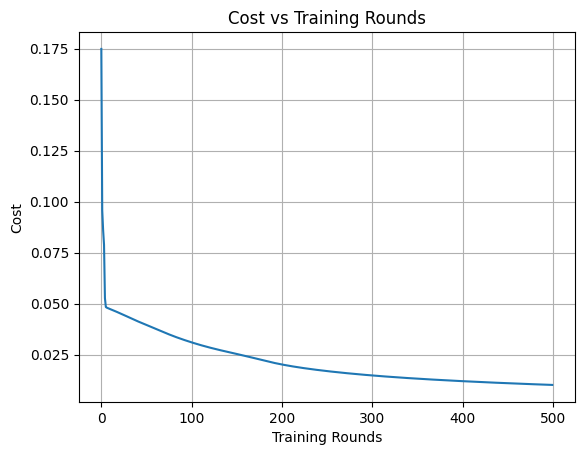

In [33]:
# Plotting the Cost Function
plt.plot(range(training_rounds),track_cost)
plt.xlabel('Training Rounds')
plt.ylabel('Cost')
plt.title('Cost vs Training Rounds')
plt.grid(True)
plt.show()

In [ ]:
# # Uncomment below lines to see predicted digits and actual digits after training (only if batch size is small)
# # Predicted Digits
# predictions = np.argmax(net.output, axis=1)
# print("Predicted Digits: \n", predictions)

# # Actual Digits/Labels
# actual_labels = np.argmax(targets, axis=1)
# print("Actual Digits:\n", actual_labels)


In [35]:
# Final Forward Pass
net.forward()

# Final Cost
final_cost = cost(net.output, targets)
print("Final Cost after training: ", final_cost)


Final Cost after training:  0.01021336


In [36]:
# Testing The Network
print(f"Testing with {test_size} samples...")
test_idxs = list(range(batch_size, batch_size + test_size))
test_images = pixels[test_idxs].astype(np.float32) / 255.0
test_labels = labels[test_idxs]

# Set input layer data to batch images
input_layer.data = test_images

# Forward pass
net.forward()

# Get predictions
test_predictions = np.argmax(net.output, axis=1)

Testing with 3000 samples...


In [ ]:
# # Predictions vs Actual Digits (Uncomment if want to see and test size is not too large)

# print(f"Predictions for test images from {batch_size} to {batch_size + test_size}:\n", test_predictions)
# print(f"Actual digits:\n", test_labels)

In [38]:
# Calculate accuracy
accuracy = np.mean(test_predictions == test_labels) * 100
print(f"Model accuracy on this batch: {accuracy:.2f}%")

Model accuracy on this batch: 83.17%
